### `Task 1`
1. make sure you have `ML5G-PS-005_train.csv` and `ML5G-PS-005_test.csv` in same directory as this file
2. make sure you have `Task_data_handler.py` in same directory as this file

3. Change `time_t` valuable (from 0 to 600) which is detection time and run-all cells in order to get the predictions

### Import all modules

In [1]:
import math
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, mean_squared_error

from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

import re
import Task_data_handler as Th

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Create new dataset from training and testing datasets

In [2]:
# time_t's value must be changed to any detection time which ranges from 0 to 600
time_t = 70

In [3]:
# collect all rows which are at specific detection time (time_t)
df, target, label, train_size = Th.get_df_preprocessed(time_limit=time_t)
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)) # to avoid column name error, rename all columns
print(df.shape, target.shape, label.shape, train_size)

(900, 3325) (900,) (900,) 600


In [4]:
# The collected dataset from training.csv and test.csv must be in different variables
X_train, y_train, X_test, y_test, train_label, test_label = Th.split(df, target, label, train_size)
print(X_train.shape, X_test.shape, train_label.shape)

(600, 3325) (300, 3325) (600,)


In [5]:
# copy the training set into normal data (network failure doesn't occur) and abnormal data (network failure occur)
normal_data = pd.DataFrame(columns=['Detection time', 'amf.amf.app.five-g.RM.RegInitFail'])
abnormal_data = pd.DataFrame(columns=['Detection time', 'amf.amf.app.five-g.RM.RegInitFail'])
for i in range(len(X_train)):
    tmp_df = pd.DataFrame([[time_t, y_train.iloc[i]]], 
        columns=['Detection time', 'amf.amf.app.five-g.RM.RegInitFail'])
    if train_label.iloc[i] == 'normal':
        normal_data = pd.concat([normal_data, tmp_df], ignore_index=True)
    else:
        abnormal_data = pd.concat([abnormal_data, tmp_df], ignore_index=True)
print('normal: {}      abnormal: {}'.format(len(normal_data), len(abnormal_data)))

normal: 450      abnormal: 150


In [6]:
# show statistics for normal data at detection time
normal_data.describe()

,amf.amf.app.five-g.RM.RegInitFail
count,450.000000
mean,1.037778
std,1.602029
min,0.000000
25%,0.000000
50%,0.000000
75%,2.000000
max,14.000000


In [7]:
# show statistics for abnormal data at detection time
abnormal_data.describe()

,amf.amf.app.five-g.RM.RegInitFail
count,150.000000
mean,1.860000
std,1.646758
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,9.000000


## Use smote to oversample the training set

In [8]:
X_train, train_label, y_train = Th.manage_imbalance(X_train, train_label, y_train)
print(X_train.shape, train_label.shape, y_train.shape)

(900, 3325) (900, 1) (900,)


# Model

### creating instances of the `ML` models

In [9]:
le = LabelEncoder()
svr_model = SVR(C=0.09, kernel='sigmoid')
bayes_model = BayesianRidge()
cat_model = CatBoostRegressor()
xgbr_model = XGBRegressor()
random_forest_model = RandomForestRegressor()

### `Train` the models

In [10]:
svr_model.fit(X_train, y_train)
bayes_model.fit(X_train, y_train)
xgbr_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)
cat_model.fit(X_train, y_train, verbose=250)

Learning rate set to 0.040267
0:	learn: 1.5305447	total: 400ms	remaining: 6m 39s
250:	learn: 0.5513720	total: 1m 8s	remaining: 3m 23s
500:	learn: 0.2561480	total: 2m 3s	remaining: 2m 3s
750:	learn: 0.1275106	total: 3m 2s	remaining: 1m
999:	learn: 0.0675239	total: 3m 52s	remaining: 0us


## Use ``Threshold`` to separate the dataset

threshold is any value v in which if target value is about that value v, the network failure occurs and if it is less than the same value v, then network failure does not occur

use the predicted value array and threshold to generate true and false matrix in form of integers

In [11]:
def my_pred(pred, threshold=2):
    return (pred >= threshold).astype(int)

## search for best threshold value

In [12]:
y = test_label.factorize()[0]
models ={ 
        'SVR': svr_model, 
        'Cat': cat_model,
        'XGBR' : xgbr_model,
        'Bayesian Ridge' : bayes_model,
        'Random Forest': random_forest_model,
}

min_threshold = 0
max_threshold = 100
steps = 1

# instead of searching for thousand times, this if else block will prevent that there by saving a lot of time
if time_t == 30:      
        min_threshold = 0
        max_threshold = 3000
        steps = 1000
elif time_t < 150:
        max_threshold = 300
        steps = 100
        

results = pd.DataFrame(columns=['Model', 'F1', 'Threshold', 'Accurancy'])
for i in range(min_threshold, max_threshold):
    for name, model in models.items():
        pred = my_pred(model.predict(X_test), threshold=i/steps)
        accur = accuracy_score(y, pred)
        tmp_df = pd.DataFrame([[name, f1_score(y, pred, average=None)[0], i/steps, accur]], columns=['Model', 'F1', 'Threshold', 'Accurancy'])
        results = pd.concat([results, tmp_df], ignore_index=True)
results = results.sort_values(by=['F1', 'Accurancy'], ascending = [False, False])

## show one ```best``` result for each model 

In [13]:
# Write a Summary of the findings for recording purposes
print('Detection time:', time_t)
top_models = []
summary = pd.DataFrame(columns=['Model', 'F1', 'Threshold', 'Accurancy'])
i = 0
while len(top_models) < len(models):
    if results.iloc[i]['Model'] not in top_models:
        accur = accuracy_score(y, my_pred(svr_model.predict(X_test), threshold=results.iloc[i]['Threshold']))
        tmp_df = pd.DataFrame([[results.iloc[i]['Model'], results.iloc[i]['F1'], results.iloc[i]['Threshold'], accur]], 
            columns=['Model', 'F1', 'Threshold', 'Accurancy'])
        summary = pd.concat([summary, tmp_df], ignore_index=True)
        top_models.append(results.iloc[i]['Model'])

        if results.iloc[i]['Model'] == 'SVR':
            threshold = results.iloc[i]['Threshold']
    i += 1
summary

Detection time: 70


,Model,F1,Threshold,Accurancy
0,SVR,1.000000,0.64,1.00
1,Random Forest,0.900609,2.48,0.75
2,Cat,0.886228,2.57,0.75
3,Bayesian Ridge,0.875740,2.89,0.75
4,XGBR,0.875000,2.87,0.75


## Calculate `RMSE` for sklearn

In [14]:
mse = mean_squared_error(y, my_pred(svr_model.predict(X_test), threshold=threshold))  
rmse = math.sqrt(mse)

my_rms = np.square(np.subtract(y, my_pred(svr_model.predict(X_test), threshold=threshold))).mean()   
my_rmse = math.sqrt(my_rms) 

print('sklearn RMSE:', rmse, 'My RMSE:', my_rmse)

sklearn RMSE: 0.0 My RMSE: 0.0


## show `all` results

In [15]:
# Write details of the findings
pd.set_option('display.max_rows', None)  #change None to 20 if you want to see 20 rows only
print('Detected time:', time_t)
results

Detected time: 70


,Model,F1,Threshold,Accurancy
320,SVR,1.000000,0.64,1.000000
325,SVR,1.000000,0.65,1.000000
330,SVR,1.000000,0.66,1.000000
335,SVR,1.000000,0.67,1.000000
340,SVR,1.000000,0.68,1.000000
345,SVR,1.000000,0.69,1.000000
350,SVR,1.000000,0.70,1.000000
355,SVR,1.000000,0.71,1.000000
360,SVR,1.000000,0.72,1.000000
365,SVR,1.000000,0.73,1.000000


## show confusion matrix for `SVR Model` only

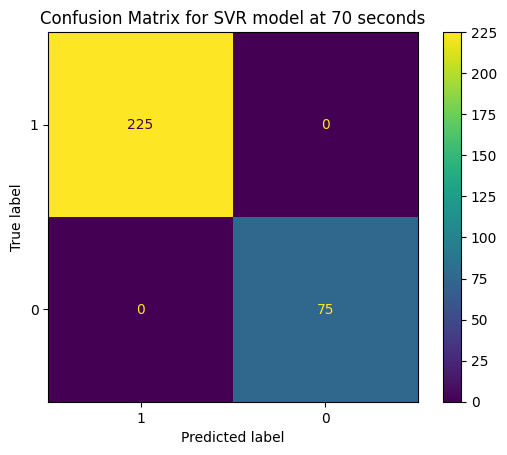

In [16]:
cm = confusion_matrix(y, my_pred(svr_model.predict(X_test), threshold=threshold))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [1, 0], )
cm_display.plot()
plt.title(f'Confusion Matrix for SVR model at {time_t} seconds')
plt.show()

## Calculate F1-score and compare it with the sklearn calculations

In [17]:
# Compare sklearn F1-Score calculations with my implememtation
def recall(matrix):
    [tp, fp], [fn, tn] = matrix
    return tp/(tp+fp)

def precision(matrix):
    [tp, fp], [fn, tn] = matrix
    return tp/(tp+fn)

def f1(matrix):
    return 2 * precision(matrix) * recall(matrix)/(precision(matrix)+recall(matrix))

print('Precision: ', precision(confusion_matrix(y, my_pred(svr_model.predict(X_test), threshold=threshold))))
print('Recall:    ', recall(confusion_matrix(y, my_pred(svr_model.predict(X_test), threshold=threshold))))
print('F1-score for my implementation F1:   ', f1(confusion_matrix(y, my_pred(svr_model.predict(X_test), threshold=threshold))))
print('F1-score for Sklearn implementation: ', f1_score(y, my_pred(svr_model.predict(X_test), threshold=threshold), average=None)[0])


Precision:  1.0
Recall:     1.0
F1-score for my implementation F1:    1.0
F1-score for Sklearn implementation:  1.0
